# R-CNN Implementation

## Dataset preparing

Fine-tuning : VOC 2012 train set

SVM         : VOC 2012 trainval set

Test        : VOC 2007 trainval set

In [103]:
import torch
from torchvision import datasets
from torchvision import transforms

train_data_finetuning = datasets.VOCDetection(root='data/finetuning',
                                              year='2012',
                                              image_set='train',
                                              download=False)

train_data_SVM = datasets.VOCDetection(root='data/SVM',
                                       year='2012',
                                       image_set='trainval',
                                       download=False)

test_data = datasets.VOCDetection(root='data/test',
                                  year='2007',
                                  image_set='trainval',
                                  download=False)

## Region Proposals

In [104]:
import selectivesearch
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [134]:
def get_iou(bb1, bb2):
    x_left = max(bb1[0], bb2[0])
    y_top = max(bb1[1], bb2[1])
    x_right = min(bb1[2], bb2[2])
    y_bottom = min(bb1[3], bb2[3])
    
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    
    bb1_area = (bb1[2] - bb1[0]) * (bb1[3] - bb1[1])
    bb2_area = (bb2[2] - bb2[0]) * (bb2[3] - bb2[1])
    
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area + 1e-20)
    
    return iou

def xyhw2topbottom(bboxes):
    out = []
    for bbox in bboxes:
        xmin = bbox[0]
        ymin = bbox[1]
        xmax = xmin + bbox[2]
        ymax = ymin + bbox[3]
        out.append((xmin, ymin, xmax, ymax))
    
    return out

def warp_roi(src, rois):
    warped_rois = []
    for roi in rois:
        temp = src[roi[1]:roi[3], roi[0]:roi[2]]
        temp = cv2.resize(temp, dsize=(224, 224), interpolation=cv2.INTER_LINEAR)
        warped_rois.append(temp)
    # warped_rois = torch.tensor(warped_rois).permute(0, 3, 2, 1)
    return warped_rois

In [147]:
def label_roi(rois, gt_rois, threshold):
    output = []
    for roi in rois:
        for gt_roi in gt_rois:
            temp = {}
            gt_roi_coord = tuple(map(int, tuple(gt_roi['bndbox'].values())))
            iou = get_iou(roi, gt_roi_coord)
            if iou >= threshold:
                temp['label'] = 'positive'
                temp['name'] = gt_roi['name']
                temp['bndbox'] = roi
                temp['iou'] = iou
            else:
                temp['label'] = 'negative'
                temp['bndbox'] = roi
                temp['iou'] = iou
            output.append(temp)
    return output

In [148]:
src, trg = train_data_finetuning[25]
src = np.array(src)

_, regions = selectivesearch.selective_search(src, scale=500, min_size=2000)

rois = [box['rect'] for box in regions]
rois = xyhw2topbottom(rois)
gt_rois = [object for object in trg['annotation']['object']]

labeled_rois = label_roi(rois, gt_rois, threshold=0.5)

warped_rois = warp_roi(src, rois)

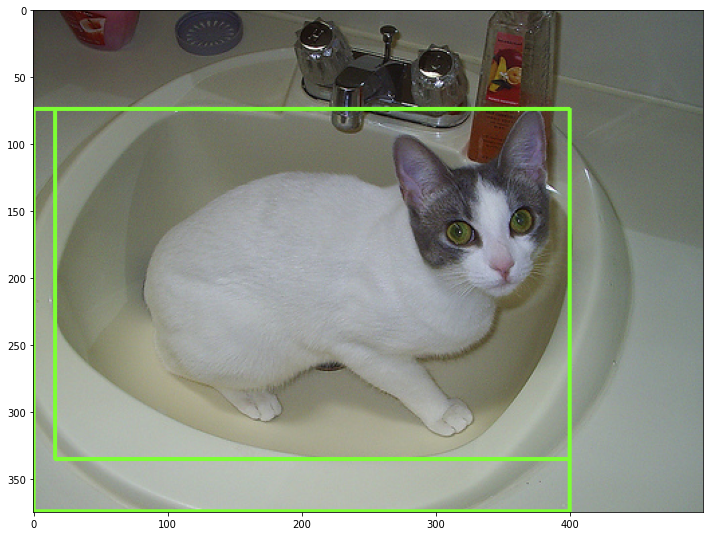

In [149]:
img = np.array(src)

for roi in labeled_rois:
    if roi['label'] == 'positive':
        img = cv2.rectangle(img, (roi['bndbox'][0], roi['bndbox'][1]), (roi['bndbox'][2], roi['bndbox'][3]), color=(125,255,51), thickness=2)

plt.figure(figsize=(12,12))
plt.imshow(img)
plt.show()

In [152]:
import torch.nn as nn
import torchvision.models as models


model = models.mobilenet_v2(pretrained=True)

model.classifier[1] = nn.Linear(model.last_channel, 20 + 1)

In [153]:
warped_rois = warped_rois.float()

AttributeError: 'list' object has no attribute 'float'

In [ ]:
output = model(warped_rois)

In [ ]:
# (num_rois, N+1)
output.shape


torch.Size([23, 21])